# Dataloader

In [73]:
import torch
from torch.utils.data import Dataset
import os
import numpy as np
from typing import Dict, List, Tuple, Union

class CubeData(Dataset):
    """Cube Dataset with Stride-based Patch Extraction and Optional Normalization"""
    def __init__(self, root: str, name: str, patch_size: int = 128, stride: int = 64, 
                 transform=None, folder=True, file=None, apply_normalization=True) -> None:
        """
        Create a dataset from a given directory with stride-based patch extraction.
        
        Args:
            root (str): Root directory path
            name (str): Name of the dataset/subdirectory
            patch_size (int): Size of patches to extract (default: 128)
            stride (int): Stride for patch extraction (default: 64)
            transform: Optional transform to be applied on patches
            folder (bool): If True, load all .npy files from directory. If False, load single file
            file (str): Specific file to load when folder=False
            apply_normalization (bool): If True, normalize patches using dataset mean and std
        """
        super().__init__()
        self.transform = transform
        self.root = root
        self.name = name
        self.patch_size = patch_size
        self.stride = stride
        self.apply_normalization = apply_normalization

        # Handle both folder and single file cases
        if folder:
            self.cubeFileNames = [f for f in os.listdir(os.path.join(self.root, name, "python")) 
                                if ".npy" in f]
        else:
            if file is None:
                raise ValueError("When folder=False, a file name must be provided!")
            self.cubeFileNames = [file]

        if len(self.cubeFileNames) == 0:
            raise ValueError("Couldn't find any numpy files in the given folder!")

        self.cubes = self.__load_cubes()
        self.patches, self.patch_positions = self.__extract_patches()
        self.file_patch_mapping = self.__create_file_patch_mapping()
        
        # Compute mean and std for normalization
        if self.apply_normalization:
            self.mean, self.std = self.__compute_mean_and_std()
            print(f"Dataset mean: {self.mean}")
            print(f"Dataset std: {self.std}")
        else:
            self.mean, self.std = None, None

    def __compute_mean_and_std(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute mean and standard deviation directly from patches.
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mean and standard deviation for each channel
        """
        patches_tensor = torch.stack([torch.from_numpy(patch) for patch in self.patches])
        mean = patches_tensor.mean(dim=(0, 2, 3))
        std = patches_tensor.std(dim=(0, 2, 3), unbiased=False)
        return mean, std

    def __load_and_reshape(self, file_path):
        """Load and reshape the cube data to ensure proper dimensionality."""
        current_cube = np.load(file_path)
        if current_cube.ndim == 2:
            current_cube = np.expand_dims(current_cube, axis=0).astype(np.float32)
        return current_cube

    def __load_cubes(self) -> Dict[str, np.ndarray]:
        """Loads all cubes contained in the folder and stores them in a dictionary indexed by filename."""
        cubes = {}
        total_size = 0
        for file in self.cubeFileNames:
            file_path = os.path.join(self.root, self.name, "python", file)
            current_cube = self.__load_and_reshape(file_path)
            fileName = file.split('.')[0]
            cubes[fileName] = current_cube
            total_size += current_cube.nbytes
        print(f"Total size of loaded cubes: {total_size / (1024**3):.2f} GB")
        return cubes

    def __extract_patches(self):
        """Extract patches from each cube using the specified patch size and stride."""
        patches = []
        patch_positions = []
        for file_name, cube in self.cubes.items():
            c, H, W = cube.shape
            for i in range(0, H - self.patch_size + 1, self.stride):
                for j in range(0, W - self.patch_size + 1, self.stride):
                    patch = cube[:, i:i+self.patch_size, j:j+self.patch_size]
                    patches.append(patch)
                    patch_positions.append((file_name, j, j+self.patch_size, i, i+self.patch_size))
        return patches, patch_positions

    def __create_file_patch_mapping(self):
        """Creates a mapping of which patches belong to which file."""
        mapping = {}
        for idx, (file_name, _, _, _, _) in enumerate(self.patch_positions):
            if file_name not in mapping:
                mapping[file_name] = []
            mapping[file_name].append(idx)
        return mapping

    def __len__(self) -> int:
        """Returns the total number of patches."""
        return len(self.patches)

    def __normalize(self, patch: torch.Tensor) -> torch.Tensor:
        """Normalize the patch using computed mean and std."""
        if self.apply_normalization:
            return (patch - self.mean[:, None, None]) / (self.std[:, None, None] + 1e-8)
        return patch

    def __getitem__(self, index: Union[int, List[int], slice]) -> Tuple[torch.Tensor, torch.Tensor, Union[Dict, List[Dict]]]:
        """
        Returns normalized patch(es), corresponding mask(s), and position information.
        """
        if isinstance(index, (torch.Tensor, np.ndarray)):
            index = index.tolist()

        if isinstance(index, int):
            patch = torch.from_numpy(self.patches[index].copy())
            position_info = {
                'file_name': self.patch_positions[index][0],
                'xmin': self.patch_positions[index][1],
                'xmax': self.patch_positions[index][2],
                'ymin': self.patch_positions[index][3],
                'ymax': self.patch_positions[index][4]
            }
            
        elif isinstance(index, list):
            patch = torch.stack([torch.from_numpy(self.patches[i].copy()) for i in index])
            position_info = [{
                'file_name': self.patch_positions[i][0],
                'xmin': self.patch_positions[i][1],
                'xmax': self.patch_positions[i][2],
                'ymin': self.patch_positions[i][3],
                'ymax': self.patch_positions[i][4]
            } for i in index]
            
        elif isinstance(index, slice):
            indices = range(index.start or 0, index.stop or len(self), index.step or 1)
            patch = torch.stack([torch.from_numpy(self.patches[i].copy()) for i in indices])
            position_info = [{
                'file_name': self.patch_positions[i][0],
                'xmin': self.patch_positions[i][1],
                'xmax': self.patch_positions[i][2],
                'ymin': self.patch_positions[i][3],
                'ymax': self.patch_positions[i][4]
            } for i in indices]

        patch = self.__normalize(patch)

        if self.transform:
            patch = self.transform(patch)

        mask = self.__computeMask(patch).to(torch.bool)
        patch = torch.nan_to_num(patch, nan=0.0)
        
        return patch, mask, position_info

    def __computeMask(self, img: torch.Tensor) -> torch.Tensor:
        """Computes a binary mask for a given patch."""
        mask = torch.zeros_like(img)
        mask[torch.where(img == 0)] = 1.0
        if torch.isnan(img).any():
            mask[torch.isnan(img)] = 1.0
        if len(img.shape) == 3:
            c, h, w = img.shape
            summed = torch.sum(mask, dim=0)
            mask = (summed == c).unsqueeze(0).float()
        else:
            n, c, h, w = img.shape
            summed = torch.sum(mask, dim=1)
            mask = (summed == c).unsqueeze(1).float()
        return mask

    def get_patches_for_file(self, file_name: str) -> List[int]:
        """Returns indices of all patches that belong to a specific file."""
        file_name = file_name.replace('.npy', '')
        return self.file_patch_mapping.get(file_name, [])

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from ml_4m.fourm.vq.vqvae import DiVAE
from models.percept_loss import TimmPerceptualLoss
from ml_4m.fourm.utils import IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD

class SpatialModel(nn.Module):
    def __init__(self, config=None):
        super().__init__()
        self.config = config
        self.in_channels = config['model']['num_channels'] if config else 1
        self.image_size = config['model']['image_size'] if config else 224
        self._init_models()
        
    def _init_models(self):
        """Initialize all model components"""
        # Initialize perceptual loss if enabled
        self.perceptloss = None
        if self.config and self.config.get('loss', {}).get('use_percept'):
            self.perceptloss = TimmPerceptualLoss(
                model_id=self.config['loss']['model_id'],
                feature_ids=self.config['loss']['feature_ids'].split('-')
            ).eval()

        # Load DiVAE
        pretrained_model_id = 'EPFL-VILAB/4M_tokenizers_rgb_16k_224-448'
        print(f"Loading pretrained DiVAE model from: {pretrained_model_id}")
        self.divae = DiVAE.from_pretrained(pretrained_model_id)
        self.divae.eval()
        
        # Freeze DiVAE parameters
        for param in self.divae.parameters():
            param.requires_grad = False
            
    def to(self, device):
        """Override to() to ensure all components move to the same device"""
        if isinstance(device, str):
            device = torch.device(device)
            
        # Move base model
        super().to(device)
        
        # Move components
        if self.perceptloss is not None:
            self.perceptloss.to(device)
        
        # Move DiVAE to device
        self.divae.to(device)
        
        return self

    @torch.no_grad()
    def forward(self, x, nan_mask=None, enc_mask=None, use_diffusion=None, timesteps=None, generator=None, verbose=False, **kwargs):
        # Get device information
        device = x.device

        # Step 1: Prepare input - resize and convert to RGB
        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x_upsampled = x_resized.repeat(1, 3, 1, 1)

        # Step 2: Normalize using ImageNet statistics
        mean_rgb = torch.tensor(IMAGENET_INCEPTION_MEAN, device=device).view(1, 3, 1, 1)
        std_rgb = torch.tensor(IMAGENET_INCEPTION_STD, device=device).view(1, 3, 1, 1)
        x_normalized = (x_upsampled - mean_rgb) / std_rgb

        # Step 3: Encode
        quant_enc, code_loss, tokens = self.divae.encode(x_normalized)

        # Step 4: Decode
        reconstructed = self.divae.decode_tokens(
            tokens,
            timesteps=timesteps or 50,
            verbose=verbose,
            image_size=self.image_size
        )

        # Step 5: Post-process output
        x_downsampled = F.interpolate(reconstructed, size=(128, 128), mode='area')
        x_downsampled = x_downsampled.mean(dim=1, keepdim=True)

        # Step 6: Compute losses
        final_recon_loss = self._compute_recon_loss(x, x_downsampled, nan_mask)
        percept_loss = self._compute_percept_loss(x, x_downsampled)

        # Step 7: Combine losses with configurable commitment weight
        commitment_weight = self.config['quantizer']['commitment_weight'] if self.config else 0
        total_loss = final_recon_loss + code_loss * commitment_weight + percept_loss

        return final_recon_loss, None, percept_loss, code_loss, tokens, x_downsampled, None
    
    import matplotlib.pyplot as plt


    def forward_with_visualization(self, x, nan_mask=None, enc_mask=None, use_diffusion=None, timesteps=None, generator=None, verbose=False,norm=True, **kwargs):
        # Step 1: Upsample input to [batch_size, 3, 224, 224]
        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        x_upsampled = x_resized.repeat(1, 3, 1, 1)

        # Step 2: Normalize using ImageNet Inception statistics
        if norm:
            mean_rgb = torch.tensor(IMAGENET_INCEPTION_MEAN, device=device).view(1, 3, 1, 1)
            std_rgb = torch.tensor(IMAGENET_INCEPTION_STD, device=device).view(1, 3, 1, 1)
            x_normalized = (x_upsampled - mean_rgb) / std_rgb
        else:
            x_normalized = x_upsampled

        # Step 3: Encode and quantize
        quant_enc, code_loss, tokens = self.divae.encode(x_normalized)

        # Step 4: Decode tokens
        reconstructed_before_down = self.divae.decode_tokens(
            tokens,
            timesteps=timesteps or 100,
            verbose=verbose,
            image_size=self.image_size
        )

        # Step 5: Downsample to original size
        x_downsampled = F.interpolate(reconstructed_before_down, size=(128, 128), mode='area')
        x_downsampled = x_downsampled.mean(dim=1, keepdim=True)

        # Consolidated Visualization
        fig, axes = plt.subplots(1, 6, figsize=(20, 5))

        # Upsampled input
        axes[0].imshow(x_resized.squeeze().detach().cpu().clamp(0,1))
        axes[0].set_title("Resized Input")
        axes[0].axis('off')
        
        axes[1].imshow(x_upsampled.squeeze().permute(1, 2, 0).detach().cpu().clamp(0,1))
        axes[1].set_title("Upsampled Input")
        axes[1].axis('off')

        # Normalized input
        axes[2].imshow(x_normalized.squeeze().permute(1, 2, 0).detach().cpu().clamp(0,1))
        axes[2].set_title("Normalized Input")
        axes[2].axis('off')

        # Quantized tokens
        axes[3].imshow(tokens.squeeze().detach().cpu(), cmap='viridis')
        axes[3].set_title("Quantized Tokens")
        axes[3].axis('off')

        # Reconstructed before downsampling
        axes[4].imshow(reconstructed_before_down.squeeze().permute(1, 2, 0).detach().cpu().clamp(0,1))
        axes[4].set_title("Reconstructed Before Downsampling")
        axes[4].axis('off')
        
        axes[5].imshow(x_downsampled.squeeze().detach().cpu().clamp(0,1))
        axes[5].set_title("Reconstructed")
        axes[5].axis('off')

        plt.tight_layout()
        plt.show()

        return None


        def _compute_recon_loss(self, input, target, nan_mask):
            """Compute reconstruction loss with proper device handling"""
            device = input.device
            nan_mask = nan_mask.to(device)
            nan_mask = ~nan_mask.bool()
            diff = (input - target) * nan_mask
            loss = torch.sum(diff.pow(2)) / torch.sum(nan_mask)
            return loss
    
    def _compute_percept_loss(self, original, reconstructed):
        """Compute perceptual loss if enabled"""
        if self.perceptloss is None:
            return torch.tensor(0.0, device=original.device)
            
        if self.in_channels == 1 and original.shape[1] == 1:
            original = original.repeat(1, 3, 1, 1)
            reconstructed = reconstructed.repeat(1, 3, 1, 1)
            
        return self.perceptloss(original, reconstructed, preprocess_inputs=True)
    
    @torch.no_grad()
    def tokenize(self, x, mask=0.0):
        """Tokenize input with proper device handling"""
        device = x.device
        
        if self.in_channels == 1 and x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
            
        mean_rgb = torch.tensor(IMAGENET_INCEPTION_MEAN, device=device).view(1, 3, 1, 1)
        std_rgb = torch.tensor(IMAGENET_INCEPTION_STD, device=device).view(1, 3, 1, 1)
        x_normalized = (x - mean_rgb) / std_rgb
        
        _, _, tokens = self.divae.encode(x_normalized)
        return tokens

def setup_model(config=None, num_gpus=None):
    """Setup model on single GPU"""
    # Initialize model
    model = SpatialModel(config)
    
    # Move to GPU if available
    if torch.cuda.is_available():
        device = torch.device('cuda:0')  # Always use first GPU
        model = model.to(device)
        print("Model running on single GPU (cuda:0)")
    else:
        device = torch.device('cpu')
        model = model.to(device)
        print("Model running on CPU")
        
    return model, device

In [57]:
import yaml
import matplotlib.pyplot as plt
with open('/home/kraju_umass_edu/Tokenizer/H3Tokenizer/config_Olivine.yaml', 'r') as file:
    config = yaml.safe_load(file)
model,device = setup_model(config)

Loading pretrained DiVAE model from: EPFL-VILAB/4M_tokenizers_rgb_16k_224-448
Model running on single GPU (cuda:0)


In [58]:
ls /work/pi_mparente_umass_edu/data/NormalizedLunarData/mineral_abundance/python/

Fe-pyroxene_geotiff.npy       olivine_geotiff.npy
IsFeO_geotiff.npy             orthopyroxene_geotiff.npy
Mg-clinopyroxene_geotiff.npy  pigeonite_geotiff.npy
agglutinates_geotiff.npy      plagioclase_geotiff.npy
ilmenite_geotiff.npy          pyroxene-total_geotiff.npy


In [75]:
dataset = CubeData(
        root="/work/pi_mparente_umass_edu/data/NormalizedLunarData/",
        name="mineral_abundance",
        patch_size=128,
        stride=64,
    folder = False,
    file='ilmenite_geotiff.npy',
    apply_normalization = False
    )
dataset_norm = CubeData(
        root="/work/pi_mparente_umass_edu/data/NormalizedLunarData/",
        name="mineral_abundance",
        patch_size=128,
        stride=64,
    folder = False,
    file='ilmenite_geotiff.npy',
    apply_normalization = True
    )

Total size of loaded cubes: 0.10 GB
Total size of loaded cubes: 0.10 GB
Dataset mean: tensor([0.0072])
Dataset std: tensor([0.0141])


No Img Norm


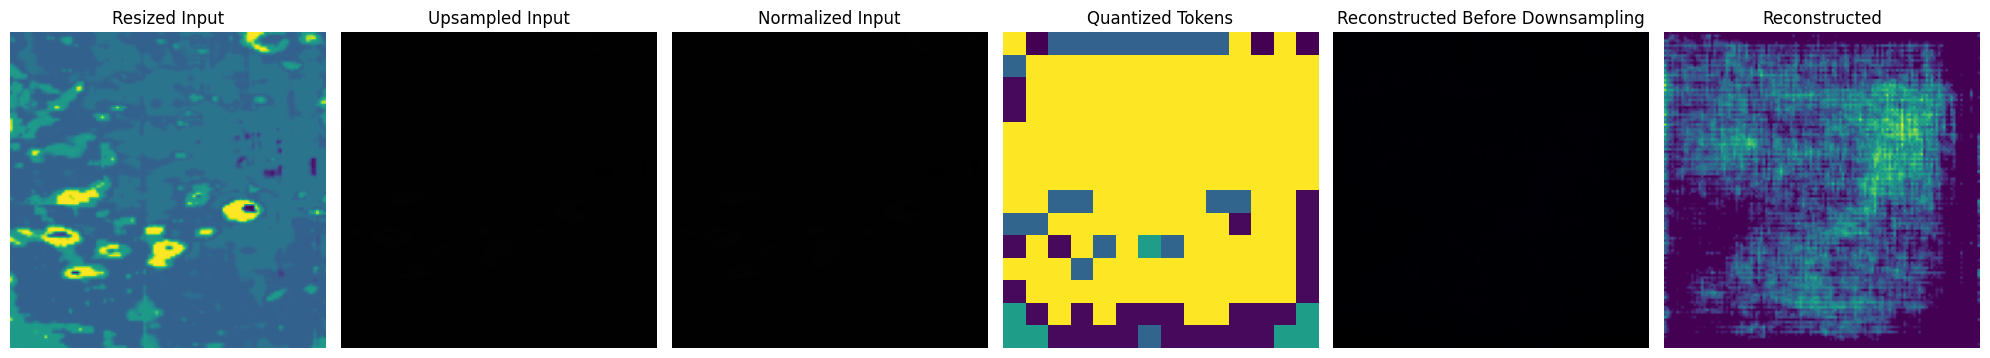

Img Norm


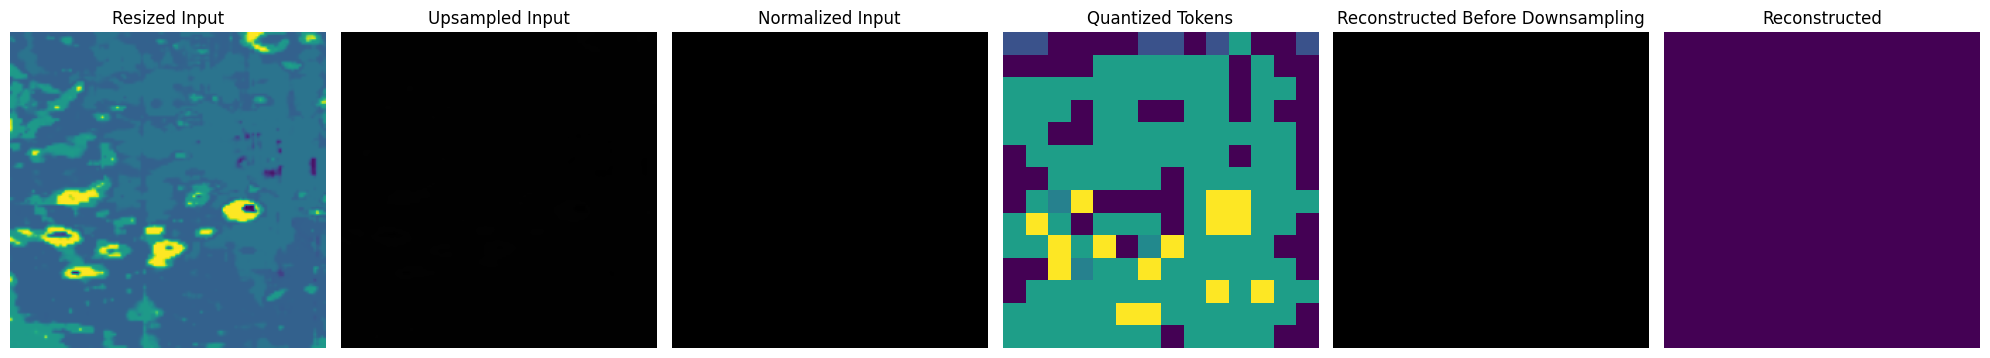

Norm Data No Img Norm


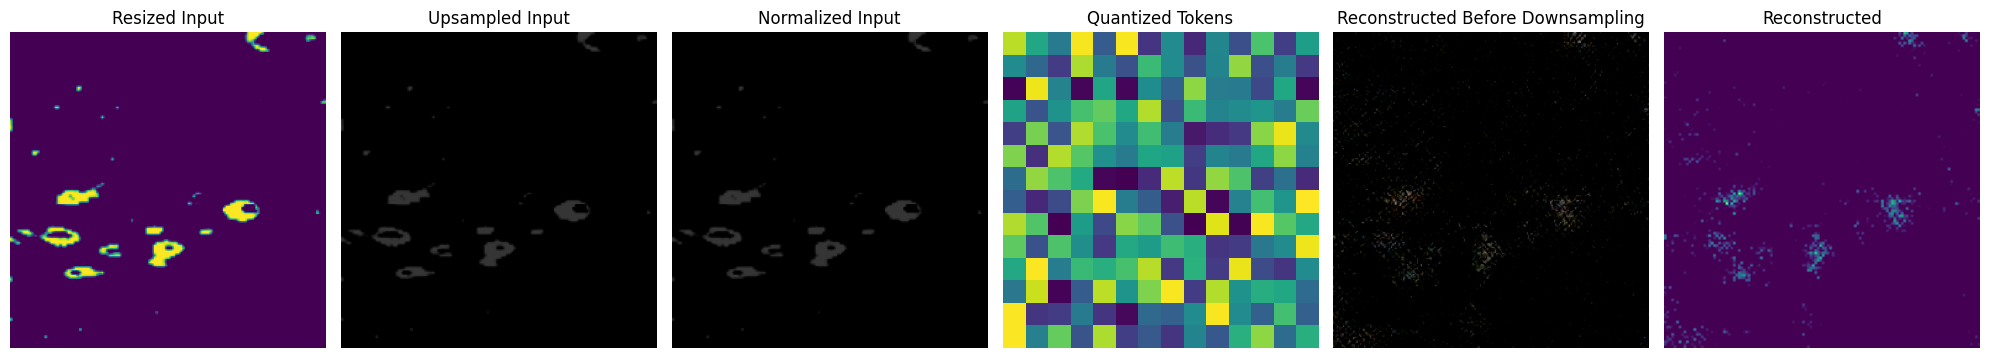

Norm Data Img Norm


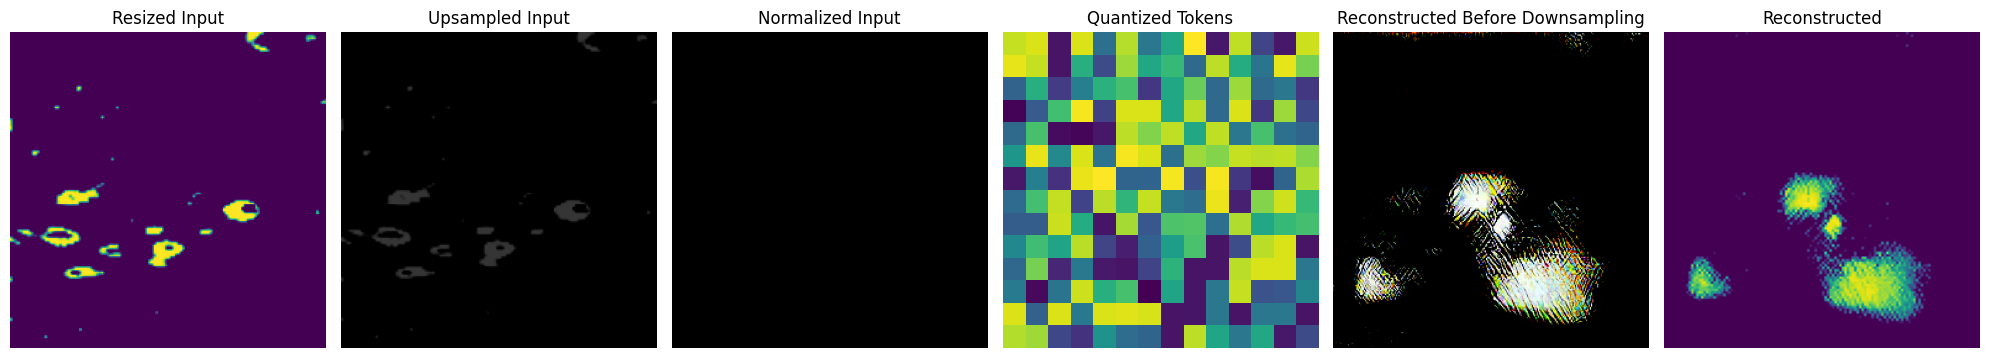

In [76]:
i = 5000
with torch.no_grad():
    print('No Img Norm')
    model.forward_with_visualization(dataset[i][0].unsqueeze(0).cuda(),dataset[i][1].cuda(),norm=False)
    print('Img Norm')
    model.forward_with_visualization(dataset[i][0].unsqueeze(0).cuda(),dataset[i][1].cuda(),norm=True)
    print('Norm Data No Img Norm')
    model.forward_with_visualization(dataset_norm[i][0].unsqueeze(0).cuda(),dataset_norm[i][1].cuda(),norm=False)
    print('Norm Data Img Norm')
    model.forward_with_visualization(dataset_norm[i][0].unsqueeze(0).cuda(),dataset_norm[i][1].cuda(),norm=True)

In [81]:
import torch
import os
# Import your SpatialModel
from model_spat import SpatialModel
def load_lightning_checkpoint(
    model, 
    checkpoint_path, 
    map_location=None, 
    strict=True  # Keep strict=False for flexible loading
):
    """
    Load a checkpoint saved by PyTorch Lightning with advanced key matching and cleaning.
    
    Args:
        model (torch.nn.Module): The PyTorch model to load state dict into.
        checkpoint_path (str): Path to the PyTorch Lightning checkpoint file.
        map_location (str or torch.device, optional): Specifies how to remap storage locations.
        strict (bool, optional): Whether to strictly enforce key matching. Defaults to False.
    
    Returns:
        torch.nn.Module: The model with loaded weights
    """
    try:
        # Validate checkpoint path
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Checkpoint file not found at {checkpoint_path}")
        
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=map_location)
        
        # Extract the state dict
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        elif 'model' in checkpoint:
            state_dict = checkpoint['model']
        else:
            state_dict = checkpoint
        
        # Get model's current state dict keys
        model_keys = list(model.state_dict().keys())
        
        # Create a mapping to handle different prefix scenarios
        cleaned_state_dict = {}
        unexpected_keys = []
        
        for k, v in state_dict.items():
            # Remove common problematic prefixes
            cleaned_key = k #.replace('model.perceptloss.', '').replace('model.perceptloss.model','')
            
            # Try to match the key exactly or with end matching
            matching_keys = [mk for mk in model_keys if cleaned_key.endswith(mk)]
            
            if matching_keys:
                # Use the first matching key
                cleaned_state_dict[matching_keys[0]] = v
            else:
                # Keep track of unexpected keys for debugging
                unexpected_keys.append(k)
        
        # Detailed logging of matching process
        #print("Matched keys:", list(cleaned_state_dict.keys()))
        #print('\n\n\n')
        print("Unexpected keys:", unexpected_keys)
        #print('\n\n\n')
        #print("Model's expected keys:", model_keys)
        
        # Attempt to load the cleaned state dictionary
        try:
            model.load_state_dict(cleaned_state_dict, strict=strict)
        except Exception as e:
            print("Detailed loading error:")
            print(f"Error: {e}")
            
            # More detailed error handling
            print("\nKeys in cleaned state dict:", list(cleaned_state_dict.keys()))
            print("\nKeys in model's state dict:", model_keys)
            
            raise ValueError(f"Failed to load state dict: {e}")
        
        # Set the model to evaluation mode
        model.eval()
        
        return model
    
    except Exception as e:
        print(f"Error loading PyTorch Lightning checkpoint: {e}")
        raise

# Utility function for model loading
def load_model(model, checkpoint_path):
    """
    Wrapper function to load a model from a checkpoint.
    
    Args:
        model (torch.nn.Module): The model to load weights into.
        checkpoint_path (str): Path to the checkpoint file.
    
    Returns:
        torch.nn.Module: The model with loaded weights
    """
    return load_lightning_checkpoint(
        model=model, 
        checkpoint_path=checkpoint_path,
        strict=True  # Use False for more flexible loading
    )

# Debugging helper function
def compare_state_dict_keys(checkpoint_path):
    """
    Print out the keys from a checkpoint for detailed inspection.
    
    Args:
        checkpoint_path (str): Path to the checkpoint file.
    """
    checkpoint = torch.load(checkpoint_path)
    
    # Check different possible locations of state dict
    if 'state_dict' in checkpoint:
        keys = checkpoint['state_dict'].keys()
        print("Keys from 'state_dict':")
    elif 'model' in checkpoint:
        keys = checkpoint['model'].keys()
        print("Keys from 'model':")
    else:
        keys = checkpoint.keys()
        print("Keys from direct checkpoint:")
    
    for key in keys:
        print(key)
       
spatmodel = SpatialModel(config).to(device)
spatmodel.eval()  # Set the model to evaluation mode

loaded_model = load_model(
    model=spatmodel, 
    checkpoint_path='/home/kraju_umass_edu/Tokenizer/H3Tokenizer/v1/Global20ppd_MLR_LPGRS_geotiffCa_tokens_lr1e4/mae-epoch=22-val_loss=0.00.ckpt',
 )

Loading pretrained DiVAE model from: EPFL-VILAB/4M_tokenizers_rgb_16k_224-448
1000
Froze decoder parameter: decoder.time_embed.0.weight
Froze decoder parameter: decoder.time_embed.0.bias
Froze decoder parameter: decoder.time_embed.2.weight
Froze decoder parameter: decoder.time_embed.2.bias
Froze decoder parameter: decoder.input_blocks.0.0.weight
Froze decoder parameter: decoder.input_blocks.0.0.bias
Froze decoder parameter: decoder.input_blocks.1.0.in_layers.0.weight
Froze decoder parameter: decoder.input_blocks.1.0.in_layers.0.bias
Froze decoder parameter: decoder.input_blocks.1.0.in_layers.2.weight
Froze decoder parameter: decoder.input_blocks.1.0.in_layers.2.bias
Froze decoder parameter: decoder.input_blocks.1.0.emb_layers.1.weight
Froze decoder parameter: decoder.input_blocks.1.0.emb_layers.1.bias
Froze decoder parameter: decoder.input_blocks.1.0.out_layers.0.weight
Froze decoder parameter: decoder.input_blocks.1.0.out_layers.0.bias
Froze decoder parameter: decoder.input_blocks.1.0

/tmp/ipykernel_1077348/706045890.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_location)


Unexpected keys: []
Detailed loading error:
Error: Error(s) in loading state_dict for SpatialModel:
	Missing key(s) in state_dict: "perceptloss.model.cls_token", "perceptloss.model.pos_embed", "perceptloss.model.patch_embed.proj.weight", "perceptloss.model.patch_embed.proj.bias", "perceptloss.model.blocks.0.norm1.weight", "perceptloss.model.blocks.0.norm1.bias", "perceptloss.model.blocks.0.attn.qkv.weight", "perceptloss.model.blocks.0.attn.qkv.bias", "perceptloss.model.blocks.0.attn.proj.weight", "perceptloss.model.blocks.0.attn.proj.bias", "perceptloss.model.blocks.0.norm2.weight", "perceptloss.model.blocks.0.norm2.bias", "perceptloss.model.blocks.0.mlp.fc1.weight", "perceptloss.model.blocks.0.mlp.fc1.bias", "perceptloss.model.blocks.0.mlp.fc2.weight", "perceptloss.model.blocks.0.mlp.fc2.bias", "perceptloss.model.blocks.1.norm1.weight", "perceptloss.model.blocks.1.norm1.bias", "perceptloss.model.blocks.1.attn.qkv.weight", "perceptloss.model.blocks.1.attn.qkv.bias", "perceptloss.model.

ValueError: Failed to load state dict: Error(s) in loading state_dict for SpatialModel:
	Missing key(s) in state_dict: "perceptloss.model.cls_token", "perceptloss.model.pos_embed", "perceptloss.model.patch_embed.proj.weight", "perceptloss.model.patch_embed.proj.bias", "perceptloss.model.blocks.0.norm1.weight", "perceptloss.model.blocks.0.norm1.bias", "perceptloss.model.blocks.0.attn.qkv.weight", "perceptloss.model.blocks.0.attn.qkv.bias", "perceptloss.model.blocks.0.attn.proj.weight", "perceptloss.model.blocks.0.attn.proj.bias", "perceptloss.model.blocks.0.norm2.weight", "perceptloss.model.blocks.0.norm2.bias", "perceptloss.model.blocks.0.mlp.fc1.weight", "perceptloss.model.blocks.0.mlp.fc1.bias", "perceptloss.model.blocks.0.mlp.fc2.weight", "perceptloss.model.blocks.0.mlp.fc2.bias", "perceptloss.model.blocks.1.norm1.weight", "perceptloss.model.blocks.1.norm1.bias", "perceptloss.model.blocks.1.attn.qkv.weight", "perceptloss.model.blocks.1.attn.qkv.bias", "perceptloss.model.blocks.1.attn.proj.weight", "perceptloss.model.blocks.1.attn.proj.bias", "perceptloss.model.blocks.1.norm2.weight", "perceptloss.model.blocks.1.norm2.bias", "perceptloss.model.blocks.1.mlp.fc1.weight", "perceptloss.model.blocks.1.mlp.fc1.bias", "perceptloss.model.blocks.1.mlp.fc2.weight", "perceptloss.model.blocks.1.mlp.fc2.bias", "perceptloss.model.blocks.2.norm1.weight", "perceptloss.model.blocks.2.norm1.bias", "perceptloss.model.blocks.2.attn.qkv.weight", "perceptloss.model.blocks.2.attn.qkv.bias", "perceptloss.model.blocks.2.attn.proj.weight", "perceptloss.model.blocks.2.attn.proj.bias", "perceptloss.model.blocks.2.norm2.weight", "perceptloss.model.blocks.2.norm2.bias", "perceptloss.model.blocks.2.mlp.fc1.weight", "perceptloss.model.blocks.2.mlp.fc1.bias", "perceptloss.model.blocks.2.mlp.fc2.weight", "perceptloss.model.blocks.2.mlp.fc2.bias", "perceptloss.model.blocks.3.norm1.weight", "perceptloss.model.blocks.3.norm1.bias", "perceptloss.model.blocks.3.attn.qkv.weight", "perceptloss.model.blocks.3.attn.qkv.bias", "perceptloss.model.blocks.3.attn.proj.weight", "perceptloss.model.blocks.3.attn.proj.bias", "perceptloss.model.blocks.3.norm2.weight", "perceptloss.model.blocks.3.norm2.bias", "perceptloss.model.blocks.3.mlp.fc1.weight", "perceptloss.model.blocks.3.mlp.fc1.bias", "perceptloss.model.blocks.3.mlp.fc2.weight", "perceptloss.model.blocks.3.mlp.fc2.bias", "perceptloss.model.blocks.4.norm1.weight", "perceptloss.model.blocks.4.norm1.bias", "perceptloss.model.blocks.4.attn.qkv.weight", "perceptloss.model.blocks.4.attn.qkv.bias", "perceptloss.model.blocks.4.attn.proj.weight", "perceptloss.model.blocks.4.attn.proj.bias", "perceptloss.model.blocks.4.norm2.weight", "perceptloss.model.blocks.4.norm2.bias", "perceptloss.model.blocks.4.mlp.fc1.weight", "perceptloss.model.blocks.4.mlp.fc1.bias", "perceptloss.model.blocks.4.mlp.fc2.weight", "perceptloss.model.blocks.4.mlp.fc2.bias", "perceptloss.model.blocks.5.norm1.weight", "perceptloss.model.blocks.5.norm1.bias", "perceptloss.model.blocks.5.attn.qkv.weight", "perceptloss.model.blocks.5.attn.qkv.bias", "perceptloss.model.blocks.5.attn.proj.weight", "perceptloss.model.blocks.5.attn.proj.bias", "perceptloss.model.blocks.5.norm2.weight", "perceptloss.model.blocks.5.norm2.bias", "perceptloss.model.blocks.5.mlp.fc1.weight", "perceptloss.model.blocks.5.mlp.fc1.bias", "perceptloss.model.blocks.5.mlp.fc2.weight", "perceptloss.model.blocks.5.mlp.fc2.bias", "perceptloss.model.blocks.6.norm1.weight", "perceptloss.model.blocks.6.norm1.bias", "perceptloss.model.blocks.6.attn.qkv.weight", "perceptloss.model.blocks.6.attn.qkv.bias", "perceptloss.model.blocks.6.attn.proj.weight", "perceptloss.model.blocks.6.attn.proj.bias", "perceptloss.model.blocks.6.norm2.weight", "perceptloss.model.blocks.6.norm2.bias", "perceptloss.model.blocks.6.mlp.fc1.weight", "perceptloss.model.blocks.6.mlp.fc1.bias", "perceptloss.model.blocks.6.mlp.fc2.weight", "perceptloss.model.blocks.6.mlp.fc2.bias", "perceptloss.model.blocks.7.norm1.weight", "perceptloss.model.blocks.7.norm1.bias", "perceptloss.model.blocks.7.attn.qkv.weight", "perceptloss.model.blocks.7.attn.qkv.bias", "perceptloss.model.blocks.7.attn.proj.weight", "perceptloss.model.blocks.7.attn.proj.bias", "perceptloss.model.blocks.7.norm2.weight", "perceptloss.model.blocks.7.norm2.bias", "perceptloss.model.blocks.7.mlp.fc1.weight", "perceptloss.model.blocks.7.mlp.fc1.bias", "perceptloss.model.blocks.7.mlp.fc2.weight", "perceptloss.model.blocks.7.mlp.fc2.bias", "perceptloss.model.blocks.8.norm1.weight", "perceptloss.model.blocks.8.norm1.bias", "perceptloss.model.blocks.8.attn.qkv.weight", "perceptloss.model.blocks.8.attn.qkv.bias", "perceptloss.model.blocks.8.attn.proj.weight", "perceptloss.model.blocks.8.attn.proj.bias", "perceptloss.model.blocks.8.norm2.weight", "perceptloss.model.blocks.8.norm2.bias", "perceptloss.model.blocks.8.mlp.fc1.weight", "perceptloss.model.blocks.8.mlp.fc1.bias", "perceptloss.model.blocks.8.mlp.fc2.weight", "perceptloss.model.blocks.8.mlp.fc2.bias", "perceptloss.model.blocks.9.norm1.weight", "perceptloss.model.blocks.9.norm1.bias", "perceptloss.model.blocks.9.attn.qkv.weight", "perceptloss.model.blocks.9.attn.qkv.bias", "perceptloss.model.blocks.9.attn.proj.weight", "perceptloss.model.blocks.9.attn.proj.bias", "perceptloss.model.blocks.9.norm2.weight", "perceptloss.model.blocks.9.norm2.bias", "perceptloss.model.blocks.9.mlp.fc1.weight", "perceptloss.model.blocks.9.mlp.fc1.bias", "perceptloss.model.blocks.9.mlp.fc2.weight", "perceptloss.model.blocks.9.mlp.fc2.bias", "perceptloss.model.blocks.10.norm1.weight", "perceptloss.model.blocks.10.norm1.bias", "perceptloss.model.blocks.10.attn.qkv.weight", "perceptloss.model.blocks.10.attn.qkv.bias", "perceptloss.model.blocks.10.attn.proj.weight", "perceptloss.model.blocks.10.attn.proj.bias", "perceptloss.model.blocks.10.norm2.weight", "perceptloss.model.blocks.10.norm2.bias", "perceptloss.model.blocks.10.mlp.fc1.weight", "perceptloss.model.blocks.10.mlp.fc1.bias", "perceptloss.model.blocks.10.mlp.fc2.weight", "perceptloss.model.blocks.10.mlp.fc2.bias", "perceptloss.model.blocks.11.norm1.weight", "perceptloss.model.blocks.11.norm1.bias", "perceptloss.model.blocks.11.attn.qkv.weight", "perceptloss.model.blocks.11.attn.qkv.bias", "perceptloss.model.blocks.11.attn.proj.weight", "perceptloss.model.blocks.11.attn.proj.bias", "perceptloss.model.blocks.11.norm2.weight", "perceptloss.model.blocks.11.norm2.bias", "perceptloss.model.blocks.11.mlp.fc1.weight", "perceptloss.model.blocks.11.mlp.fc1.bias", "perceptloss.model.blocks.11.mlp.fc2.weight", "perceptloss.model.blocks.11.mlp.fc2.bias", "perceptloss.model.norm.weight", "perceptloss.model.norm.bias", "perceptloss.feature_extractor.pos_embed", "perceptloss.feature_extractor.cls_token", "perceptloss.feature_extractor.patch_embed.proj.weight", "perceptloss.feature_extractor.patch_embed.proj.bias", "perceptloss.feature_extractor.blocks.0.norm1.weight", "perceptloss.feature_extractor.blocks.0.norm1.bias", "perceptloss.feature_extractor.blocks.0.attn.qkv.weight", "perceptloss.feature_extractor.blocks.0.attn.qkv.bias", "perceptloss.feature_extractor.blocks.0.attn.proj.weight", "perceptloss.feature_extractor.blocks.0.attn.proj.bias", "perceptloss.feature_extractor.blocks.0.norm2.weight", "perceptloss.feature_extractor.blocks.0.norm2.bias", "perceptloss.feature_extractor.blocks.0.mlp.fc1.weight", "perceptloss.feature_extractor.blocks.0.mlp.fc1.bias", "perceptloss.feature_extractor.blocks.0.mlp.fc2.weight", "perceptloss.feature_extractor.blocks.0.mlp.fc2.bias", "perceptloss.feature_extractor.blocks.1.norm1.weight", "perceptloss.feature_extractor.blocks.1.norm1.bias", "perceptloss.feature_extractor.blocks.1.attn.qkv.weight", "perceptloss.feature_extractor.blocks.1.attn.qkv.bias", "perceptloss.feature_extractor.blocks.1.attn.proj.weight", "perceptloss.feature_extractor.blocks.1.attn.proj.bias", "perceptloss.feature_extractor.blocks.1.norm2.weight", "perceptloss.feature_extractor.blocks.1.norm2.bias", "perceptloss.feature_extractor.blocks.1.mlp.fc1.weight", "perceptloss.feature_extractor.blocks.1.mlp.fc1.bias", "perceptloss.feature_extractor.blocks.1.mlp.fc2.weight", "perceptloss.feature_extractor.blocks.1.mlp.fc2.bias", "perceptloss.feature_extractor.blocks.2.norm1.weight", "perceptloss.feature_extractor.blocks.2.norm1.bias", "perceptloss.feature_extractor.blocks.2.attn.qkv.weight", "perceptloss.feature_extractor.blocks.2.attn.qkv.bias", "perceptloss.feature_extractor.blocks.2.attn.proj.weight", "perceptloss.feature_extractor.blocks.2.attn.proj.bias", "perceptloss.feature_extractor.blocks.2.norm2.weight", "perceptloss.feature_extractor.blocks.2.norm2.bias", "perceptloss.feature_extractor.blocks.2.mlp.fc1.weight", "perceptloss.feature_extractor.blocks.2.mlp.fc1.bias", "perceptloss.feature_extractor.blocks.2.mlp.fc2.weight", "perceptloss.feature_extractor.blocks.2.mlp.fc2.bias", "perceptloss.feature_extractor.blocks.3.norm1.weight", "perceptloss.feature_extractor.blocks.3.norm1.bias", "perceptloss.feature_extractor.blocks.3.attn.qkv.weight", "perceptloss.feature_extractor.blocks.3.attn.qkv.bias", "perceptloss.feature_extractor.blocks.3.attn.proj.weight", "perceptloss.feature_extractor.blocks.3.attn.proj.bias", "perceptloss.feature_extractor.blocks.3.norm2.weight", "perceptloss.feature_extractor.blocks.3.norm2.bias", "perceptloss.feature_extractor.blocks.3.mlp.fc1.weight", "perceptloss.feature_extractor.blocks.3.mlp.fc1.bias", "perceptloss.feature_extractor.blocks.3.mlp.fc2.weight", "perceptloss.feature_extractor.blocks.3.mlp.fc2.bias", "perceptloss.feature_extractor.blocks.4.norm1.weight", "perceptloss.feature_extractor.blocks.4.norm1.bias", "perceptloss.feature_extractor.blocks.4.attn.qkv.weight", "perceptloss.feature_extractor.blocks.4.attn.qkv.bias", "perceptloss.feature_extractor.blocks.4.attn.proj.weight", "perceptloss.feature_extractor.blocks.4.attn.proj.bias", "perceptloss.feature_extractor.blocks.4.norm2.weight", "perceptloss.feature_extractor.blocks.4.norm2.bias", "perceptloss.feature_extractor.blocks.4.mlp.fc1.weight", "perceptloss.feature_extractor.blocks.4.mlp.fc1.bias", "perceptloss.feature_extractor.blocks.4.mlp.fc2.weight", "perceptloss.feature_extractor.blocks.4.mlp.fc2.bias", "perceptloss.feature_extractor.blocks.5.norm1.weight", "perceptloss.feature_extractor.blocks.5.norm1.bias", "perceptloss.feature_extractor.blocks.5.attn.qkv.weight", "perceptloss.feature_extractor.blocks.5.attn.qkv.bias", "perceptloss.feature_extractor.blocks.5.attn.proj.weight", "perceptloss.feature_extractor.blocks.5.attn.proj.bias", "perceptloss.feature_extractor.blocks.5.norm2.weight", "perceptloss.feature_extractor.blocks.5.norm2.bias", "perceptloss.feature_extractor.blocks.5.mlp.fc1.weight", "perceptloss.feature_extractor.blocks.5.mlp.fc1.bias", "perceptloss.feature_extractor.blocks.5.mlp.fc2.weight", "perceptloss.feature_extractor.blocks.5.mlp.fc2.bias", "perceptloss.feature_extractor.blocks.6.norm1.weight", "perceptloss.feature_extractor.blocks.6.norm1.bias", "perceptloss.feature_extractor.blocks.6.attn.qkv.weight", "perceptloss.feature_extractor.blocks.6.attn.qkv.bias", "perceptloss.feature_extractor.blocks.6.attn.proj.weight", "perceptloss.feature_extractor.blocks.6.attn.proj.bias", "perceptloss.feature_extractor.blocks.6.norm2.weight", "perceptloss.feature_extractor.blocks.6.norm2.bias", "perceptloss.feature_extractor.blocks.6.mlp.fc1.weight", "perceptloss.feature_extractor.blocks.6.mlp.fc1.bias", "perceptloss.feature_extractor.blocks.6.mlp.fc2.weight", "perceptloss.feature_extractor.blocks.6.mlp.fc2.bias", "perceptloss.feature_extractor.blocks.7.norm1.weight", "perceptloss.feature_extractor.blocks.7.norm1.bias", "perceptloss.feature_extractor.blocks.7.attn.qkv.weight", "perceptloss.feature_extractor.blocks.7.attn.qkv.bias", "perceptloss.feature_extractor.blocks.7.attn.proj.weight", "perceptloss.feature_extractor.blocks.7.attn.proj.bias", "perceptloss.feature_extractor.blocks.7.norm2.weight", "perceptloss.feature_extractor.blocks.7.norm2.bias", "perceptloss.feature_extractor.blocks.7.mlp.fc1.weight", "perceptloss.feature_extractor.blocks.7.mlp.fc1.bias", "perceptloss.feature_extractor.blocks.7.mlp.fc2.weight", "perceptloss.feature_extractor.blocks.7.mlp.fc2.bias", "perceptloss.feature_extractor.blocks.8.norm1.weight", "perceptloss.feature_extractor.blocks.8.norm1.bias", "perceptloss.feature_extractor.blocks.8.attn.qkv.weight", "perceptloss.feature_extractor.blocks.8.attn.qkv.bias", "perceptloss.feature_extractor.blocks.8.attn.proj.weight", "perceptloss.feature_extractor.blocks.8.attn.proj.bias", "perceptloss.feature_extractor.blocks.8.norm2.weight", "perceptloss.feature_extractor.blocks.8.norm2.bias", "perceptloss.feature_extractor.blocks.8.mlp.fc1.weight", "perceptloss.feature_extractor.blocks.8.mlp.fc1.bias", "perceptloss.feature_extractor.blocks.8.mlp.fc2.weight", "perceptloss.feature_extractor.blocks.8.mlp.fc2.bias", "perceptloss.feature_extractor.blocks.9.norm1.weight", "perceptloss.feature_extractor.blocks.9.norm1.bias", "perceptloss.feature_extractor.blocks.9.attn.qkv.weight", "perceptloss.feature_extractor.blocks.9.attn.qkv.bias", "perceptloss.feature_extractor.blocks.9.attn.proj.weight", "perceptloss.feature_extractor.blocks.9.attn.proj.bias", "perceptloss.feature_extractor.blocks.9.norm2.weight", "perceptloss.feature_extractor.blocks.9.norm2.bias", "perceptloss.feature_extractor.blocks.9.mlp.fc1.weight", "perceptloss.feature_extractor.blocks.9.mlp.fc1.bias", "perceptloss.feature_extractor.blocks.9.mlp.fc2.weight", "perceptloss.feature_extractor.blocks.9.mlp.fc2.bias", "perceptloss.feature_extractor.blocks.10.norm1.weight", "perceptloss.feature_extractor.blocks.10.norm1.bias", "perceptloss.feature_extractor.blocks.10.attn.qkv.weight", "perceptloss.feature_extractor.blocks.10.attn.qkv.bias", "perceptloss.feature_extractor.blocks.10.attn.proj.weight", "perceptloss.feature_extractor.blocks.10.attn.proj.bias", "perceptloss.feature_extractor.blocks.10.norm2.weight", "perceptloss.feature_extractor.blocks.10.norm2.bias", "perceptloss.feature_extractor.blocks.10.mlp.fc1.weight", "perceptloss.feature_extractor.blocks.10.mlp.fc1.bias", "perceptloss.feature_extractor.blocks.10.mlp.fc2.weight", "perceptloss.feature_extractor.blocks.10.mlp.fc2.bias", "perceptloss.feature_extractor.blocks.11.norm1.weight", "perceptloss.feature_extractor.blocks.11.norm1.bias", "perceptloss.feature_extractor.blocks.11.attn.qkv.weight", "perceptloss.feature_extractor.blocks.11.attn.qkv.bias", "perceptloss.feature_extractor.blocks.11.attn.proj.weight", "perceptloss.feature_extractor.blocks.11.attn.proj.bias", "perceptloss.feature_extractor.blocks.11.norm2.weight", "perceptloss.feature_extractor.blocks.11.norm2.bias", "perceptloss.feature_extractor.blocks.11.mlp.fc1.weight", "perceptloss.feature_extractor.blocks.11.mlp.fc1.bias", "perceptloss.feature_extractor.blocks.11.mlp.fc2.weight", "perceptloss.feature_extractor.blocks.11.mlp.fc2.bias". 